In [77]:
import pandas as pd
import pickle
import keras
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow

In [2]:
train_path ='Project/train' #This contains 1600 covid images and 1600 normal x_ray images
test_path ='Project/test' # this contains 568 covid images and 568 normal x_ray images
#total covid images = 2168 and total norma_xray_images = 2168
#train_set_covid_images = 1600      #train_set_normal_images = 1600
#test_set_covid_images = 568        #test_set_normal_images = 568
                                 

In [3]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 20

In [4]:
#The dimension of the images we are going to define is  
img_height = 150
img_width = 150

In [5]:
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [6]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )

Found 3200 images belonging to 2 classes.
Found 1136 images belonging to 2 classes.


In [7]:
AlexNet= Sequential()

#1st conv block

AlexNet.add(Conv2D(filters=96, input_shape=(150,150,1), kernel_size=(11,11), strides=(4,4), padding='same', name = 'conv_1' ))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional block
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same',name = 'conv_2'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional block
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',name = 'conv_3'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional block
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',name = 'conv_4'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional block
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same',name = 'conv_5'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(150,150,1,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('sigmoid'))

#Model Summary
AlexNet.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 38, 38, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 38, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 38, 38, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 96)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 19, 19, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 19, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 19, 19, 256)       0

In [8]:
# Compiling the model
AlexNet.compile(loss = keras.losses.binary_crossentropy, optimizer= 'adam', metrics=['accuracy'])

In [9]:
#This is done to assign weights to unbalanced datase t so that , all features are treated equally

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0, 1: 1.0}


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [10]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="val_loss", mode= "min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [11]:
#Training the model
AlexNet.fit(train,epochs=25, validation_data=test, class_weight=cw, callbacks=callbacks_list,shuffle=True)




Epoch 1/25
160/160 [==============================] - 240s 1s/step - loss: 0.4340 - accuracy: 0.8580 - val_loss: 0.8677 - val_accuracy: 0.5000
Epoch 2/25
160/160 [==============================] - 223s 1s/step - loss: 0.3521 - accuracy: 0.9133 - val_loss: 0.8189 - val_accuracy: 0.4991
Epoch 3/25
160/160 [==============================] - 225s 1s/step - loss: 0.3304 - accuracy: 0.9172 - val_loss: 0.6725 - val_accuracy: 0.6391
Epoch 4/25
160/160 [==============================] - 227s 1s/step - loss: 0.3072 - accuracy: 0.9239 - val_loss: 0.5254 - val_accuracy: 0.7438
Epoch 5/25
160/160 [==============================] - 227s 1s/step - loss: 0.2792 - accuracy: 0.9283 - val_loss: 0.4338 - val_accuracy: 0.7905
Epoch 6/25
160/160 [==============================] - 226s 1s/step - loss: 0.2773 - accuracy: 0.9190 - val_loss: 1.7943 - val_accuracy: 0.5009
Epoch 7/25
160/160 [==============================] - 226s 1s/step - loss: 0.2596 - accuracy: 0.9264 - val_loss: 0.6694 - val_accuracy: 0.6400

<AxesSubplot:>

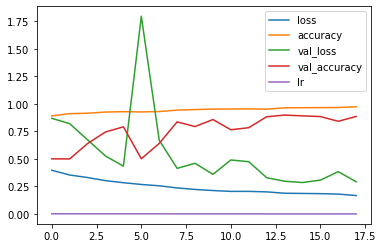

In [12]:
pd.DataFrame(AlexNet.history.history).plot()

In [40]:
img_path = 'C:/Users/DELL/OneDrive/Desktop/Project/train/x/COVID-6.png'

img = image.load_img(img_path, target_size=(150, 150),color_mode="grayscale")
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 1)


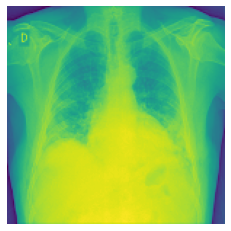

In [41]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()


In [15]:
layer_outputs = [layer.output for layer in AlexNet.layers]


In [16]:
feature_map_model = Model(inputs=AlexNet.input, outputs=layer_outputs)

In [17]:
feature_maps = feature_map_model.predict(img_tensor)

In [18]:
layer_names = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
layer_names


['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [19]:
layer_outputs = [layer.output for layer in AlexNet.layers if layer.name in layer_names]

In [20]:
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the conv_1 is =======>> (1, 38, 38, 96)
The shape of the conv_2 is =======>> (1, 38, 38, 96)
The shape of the conv_3 is =======>> (1, 38, 38, 96)
The shape of the conv_4 is =======>> (1, 19, 19, 96)
The shape of the conv_5 is =======>> (1, 19, 19, 256)


In [52]:
count=0
for i in range feature_map:
    n = count+1

SyntaxError: invalid syntax (<ipython-input-52-70482f749086>, line 1)

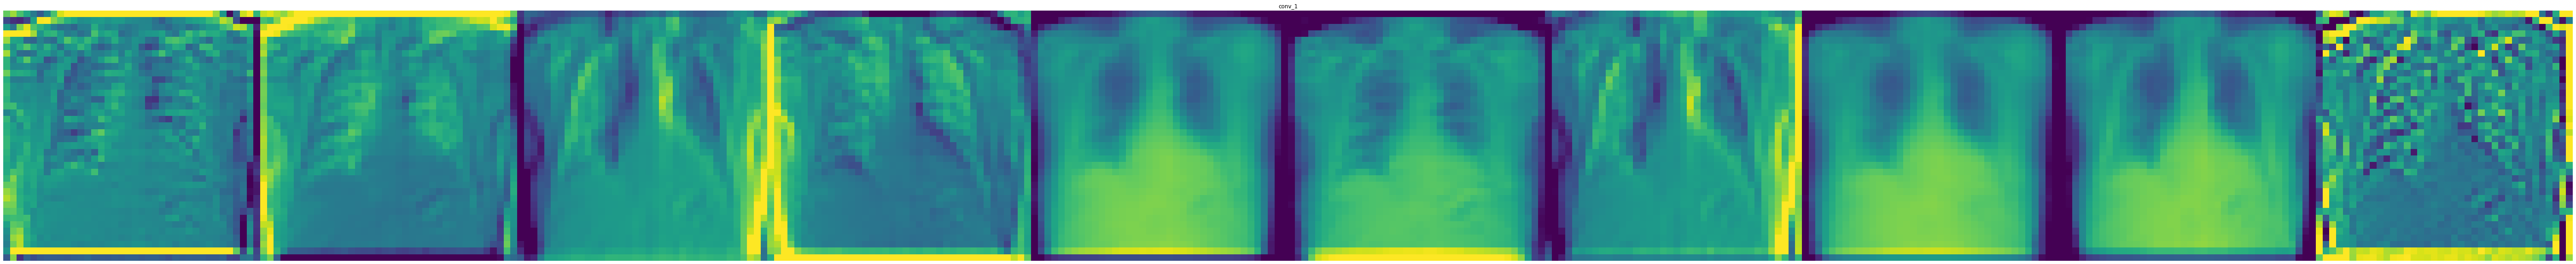

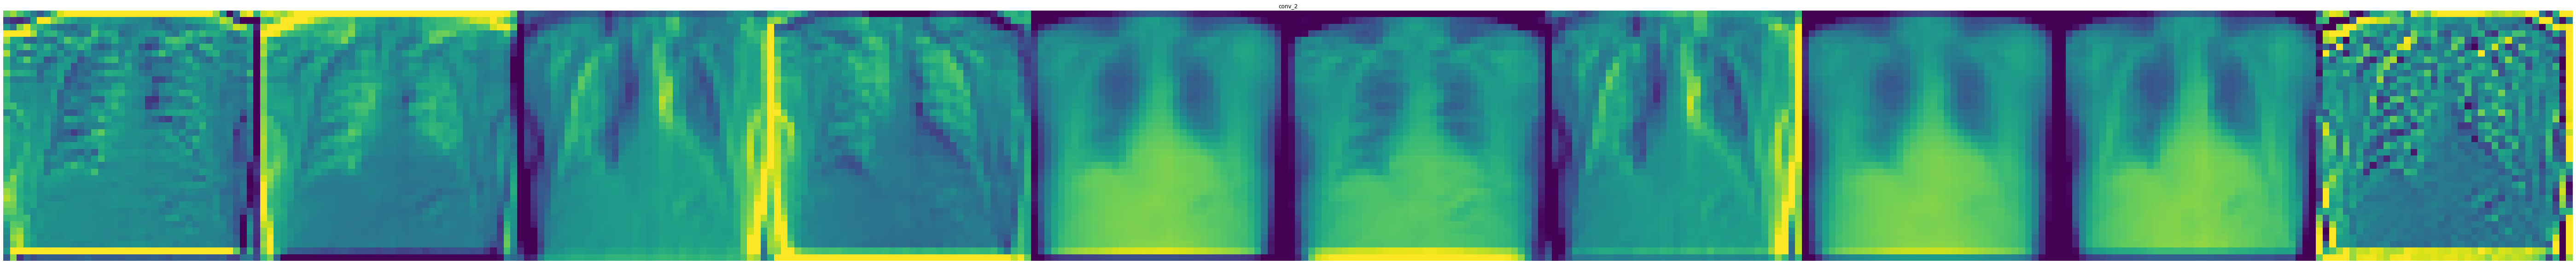

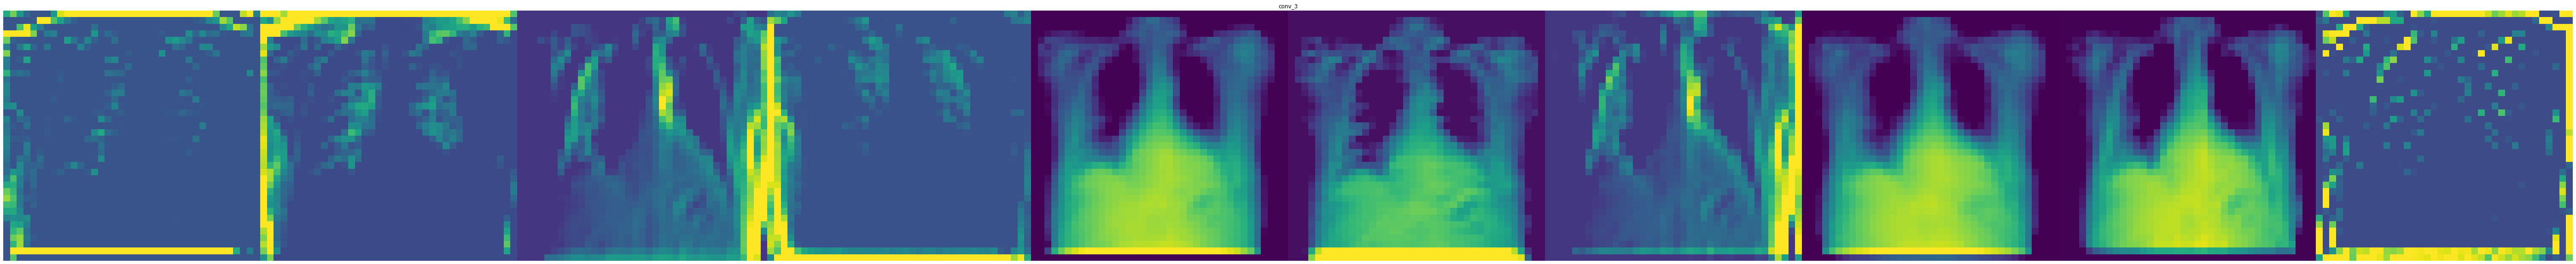

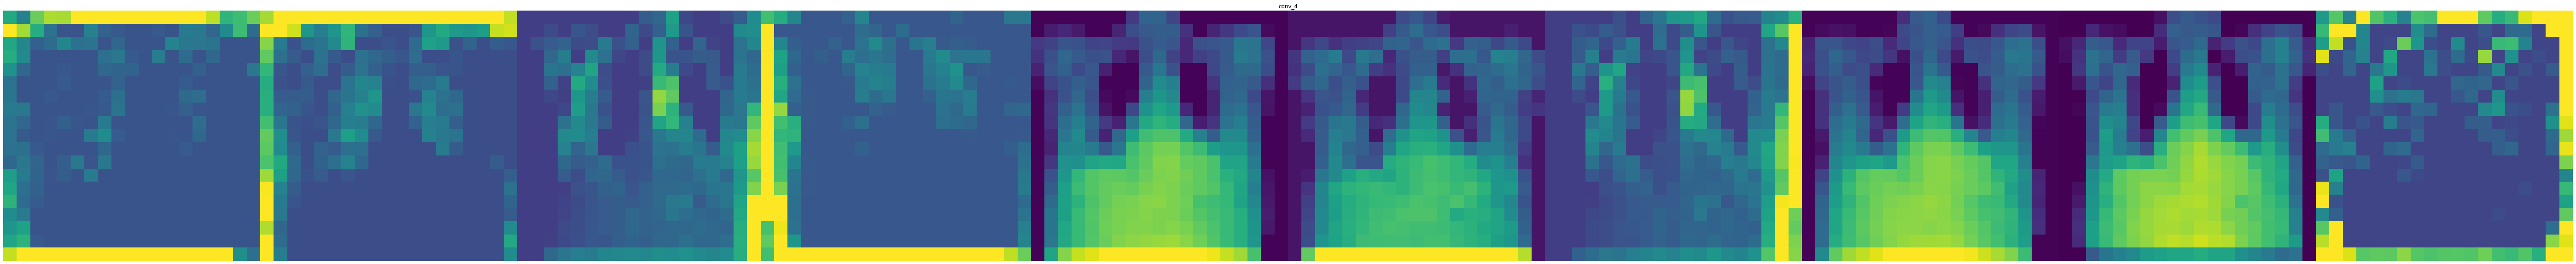

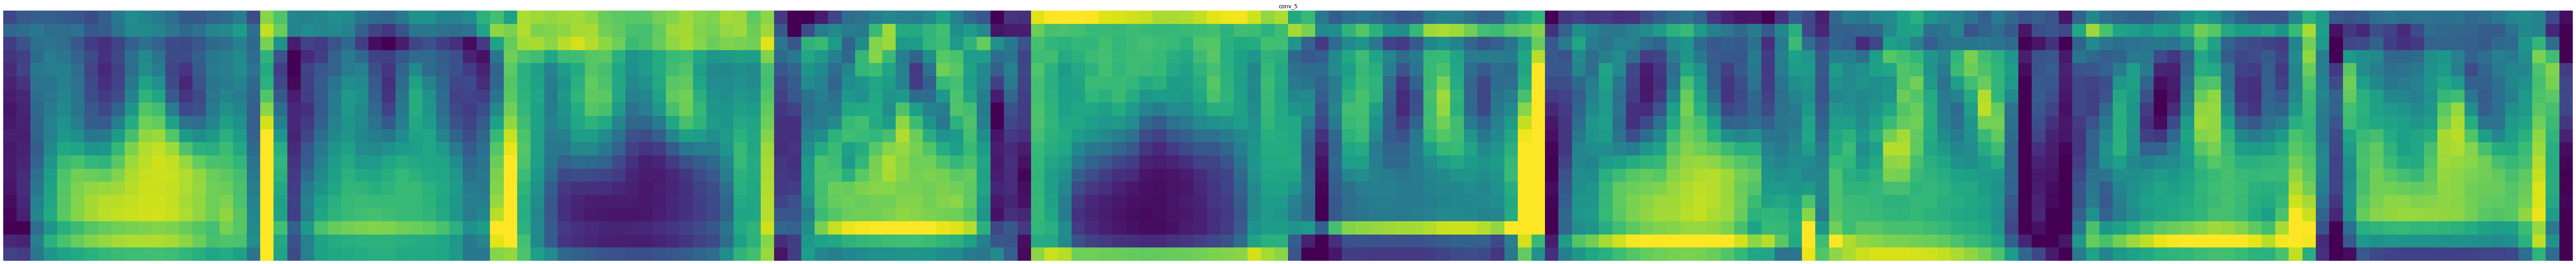

In [22]:


        
        
images_per_row = 10
max_images = 10
        
for layer_name, feature_map in zip(layer_names, feature_maps):
        
    
    # This is the number of features in the feature map
    n_features = feature_map.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]

    # We will tile the feature map in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = feature_map[0,:, :,col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
          
    # Display the grid
    scale = 10./size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto')
    plt.savefig("features.jpg")
    
plt.show()

In [23]:
test_accu = AlexNet.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

57/57 [==============================] - 16s 284ms/step - loss: 0.2918 - accuracy: 0.8847
The testing accuracy is : 88.46830725669861 %


In [24]:
preds  = AlexNet.predict(test)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<AxesSubplot:>

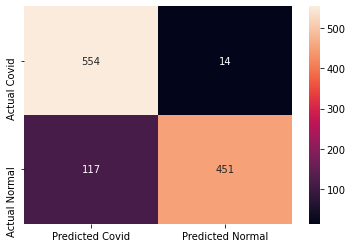

In [25]:

from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Covid", "Actual Normal"],
columns=["Predicted Covid", "Predicted Normal"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [26]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['Covid','Normal']))

              precision    recall  f1-score   support

       Covid       0.83      0.98      0.89       568
      Normal       0.97      0.79      0.87       568

    accuracy                           0.88      1136
   macro avg       0.90      0.88      0.88      1136
weighted avg       0.90      0.88      0.88      1136



In [98]:
a = AlexNet.weights[:-16]

In [102]:
 a = AlexNet.save_weights

In [104]:
extracted_layers = AlexNet.layers[:-1]
model = keras.Sequential(extracted_layers)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 38, 38, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 38, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 38, 38, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 96)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 19, 19, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 19, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 19, 19, 256)      